Assignment : build this model according to tomato classification

In [27]:
# What version of Python do you have?
import sys

import tensorflow
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.0.1-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.13 (main, Aug 25 2022, 18:24:45) 
[Clang 12.0.0 ]
Pandas 1.5.2
Scikit-Learn 1.2.0
GPU is available


In [28]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [29]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [30]:
# To load dataset using tensorflow
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [31]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [32]:
len(dataset)

68

In [33]:
68*32

2176

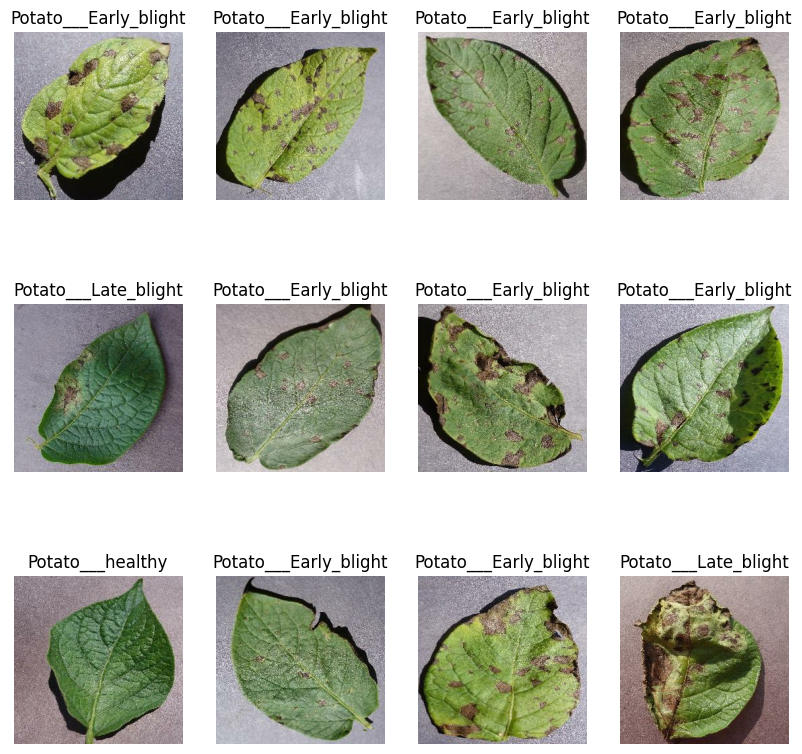

In [34]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [35]:
# Train test split of data using tensorflow
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [36]:
# Train dataset
train_dataset = dataset.take(54)
len(train_dataset)

54

In [37]:
#test dataset
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [38]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [39]:
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [40]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [41]:
def get_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(dataset)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [42]:
train_ds, val_ds, test_ds = get_partition_tf(dataset)

In [43]:
len(train_ds)

54

In [44]:
len(val_ds)

6

In [45]:
len(test_ds)

8

In [46]:
# To keep the image in the memory we use cache()
# To improve the performance we use prefetch(). While GPU is training batch1 then CPU will load batch2.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [47]:
# To resize and rescale the input images
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [48]:
# Data agumentation is a process of generating the training samples from the single image.
# We change the properties of the image like contrast, rotation, zooming, etc..
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [49]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale, # resize and rescale layer
    data_agumentation, # Data agumentation layer
    layers.Conv2D(32,(3,3),activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])
# Building a model
model.build(input_shape = input_shape)

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [52]:
# Training a model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [53]:
Epochs = 50

history = model.fit(
    train_ds,
    epochs = Epochs,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    callbacks = early_stopping
)

Epoch 1/50


2022-12-13 13:31:28.722819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 0.4786

2022-12-13 13:31:53.616337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 28s 455ms/step - loss: 0.8967 - accuracy: 0.4786 - val_loss: 0.8590 - val_accuracy: 0.4531
Epoch 2/50
54/54 [==============================] - 23s 418ms/step - loss: 0.7298 - accuracy: 0.6273 - val_loss: 0.5335 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 23s 428ms/step - loss: 0.5244 - accuracy: 0.7575 - val_loss: 0.4934 - val_accuracy: 0.7969
Epoch 4/50
54/54 [==============================] - 25s 457ms/step - loss: 0.4052 - accuracy: 0.8252 - val_loss: 0.3388 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 23s 433ms/step - loss: 0.2959 - accuracy: 0.8796 - val_loss: 0.2787 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 23s 425ms/step - loss: 0.2331 - accuracy: 0.9062 - val_loss: 0.3517 - val_accuracy: 0.8646
Epoch 7/50
54/54 [==============================] - 22s 413ms/step - loss: 0.2024 - accuracy: 0.9242 - val_loss: 0.1343 - val_accuracy: 0.9531
Epoch 8/50

In [54]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 72ms/step - loss: 0.0501 - accuracy: 0.9914


In [55]:
scores

[0.05012688785791397, 0.9913793206214905]

In [56]:
history

In [57]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [58]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

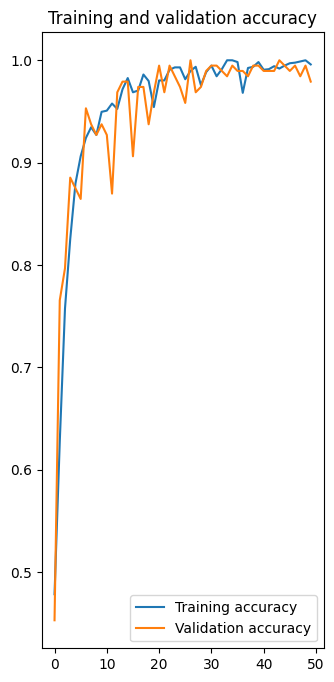

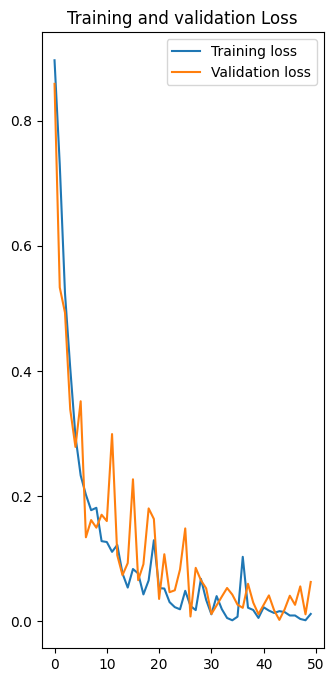

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc,label = 'Training accuracy')
plt.plot(range(Epochs),val_acc,label = 'Validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),loss,label = 'Training loss')
plt.plot(range(Epochs),val_loss,label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation Loss')

plt.show()

First image to predict :
Actual label : Potato___Late_blight
1/1 [==============================] - 0s 380ms/step


2022-12-13 13:51:00.310106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted label : Potato___Late_blight


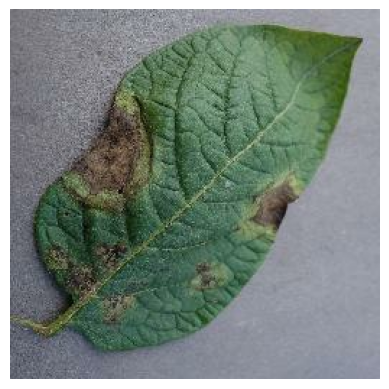

In [61]:
import numpy as np

for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('First image to predict :')
    plt.imshow(first_image)
    plt.axis('off')
    print('Actual label :',class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print('Predicted label :',class_names[np.argmax(batch_prediction[0])])

In [62]:
# making a function to prediction
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # Creating the batch

    prediction = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 15ms/step


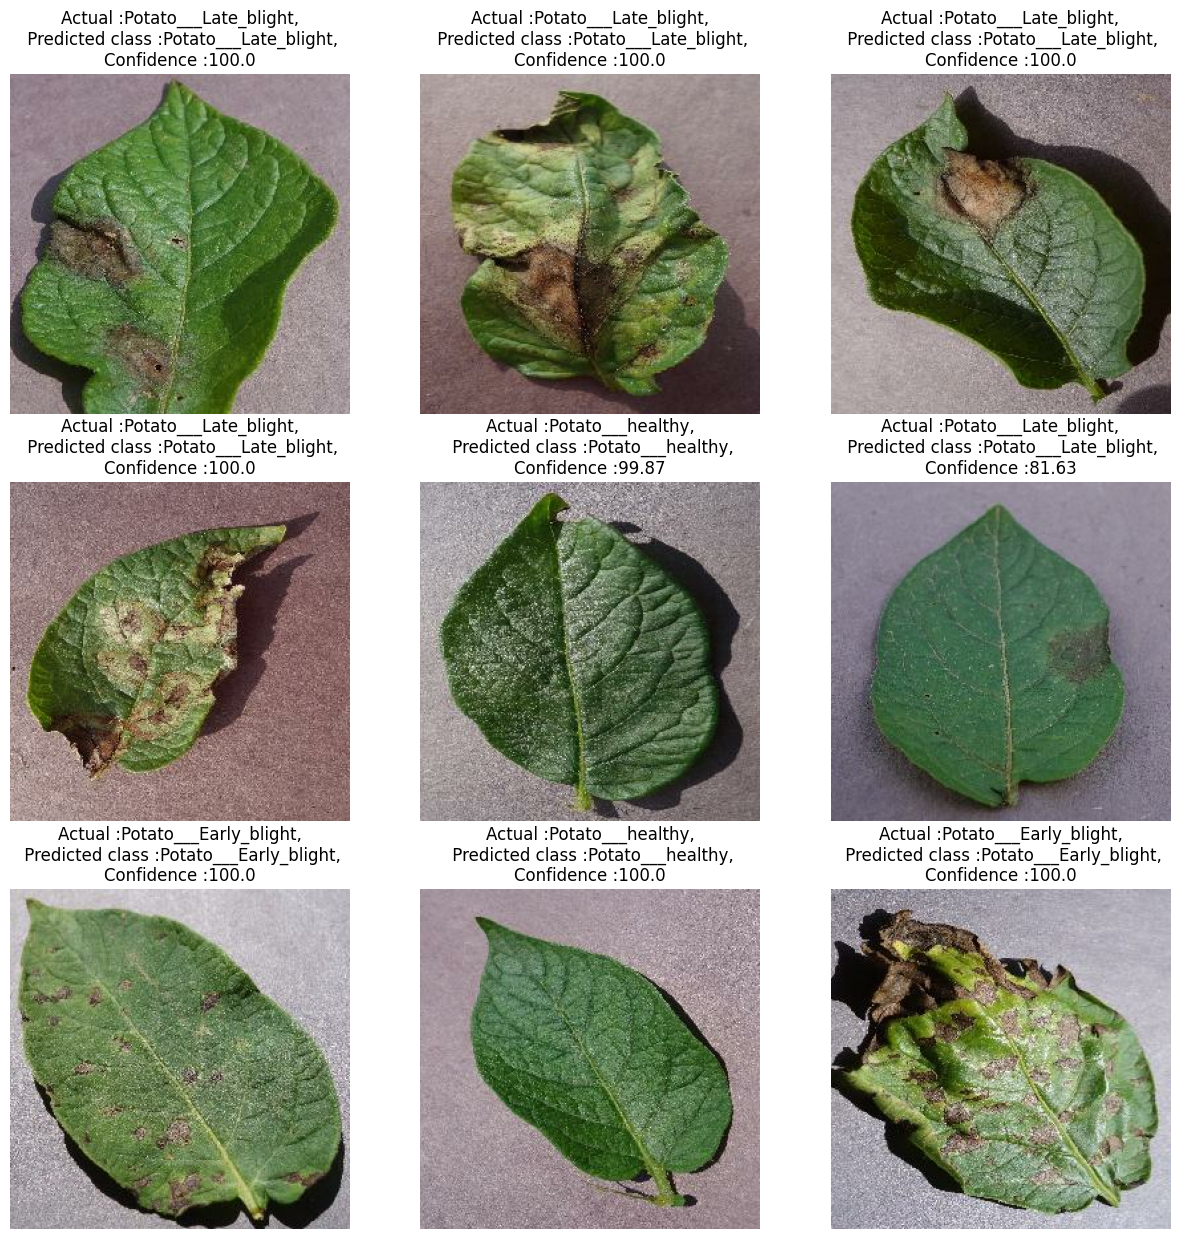

In [64]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual :{actual_class},\n Predicted class :{predicted_class},\nConfidence :{confidence}")

        plt.axis('off')

In [ ]:
import os
model_version = max([int(i) for i in os.listdir('../models/') + [0]]) + 1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/4/assets


INFO:tensorflow:Assets written to: ../models/4/assets
